In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.path import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import networkx as nx
import winsound
import time
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter("error")
import os

In [ ]:
D = 1e3
P = 1e3
L = 1e3
r = 250
d_max = 500
BS = [P/2, L/2, -D/2]

f = 187 
pH = 7.7      
sh = 0.8
T = 4
S = 34
w = 5
k = 1.5
spreading_factor = 2
m = 10
bernoulli_probability = 0.95

d = r*np.sqrt(3)
N_l = np.ceil((((P-d)/d) + 1))
N_h = np.ceil(((2*np.sqrt(3)*L-6*d+4*np.sqrt(3)*r)/(3*d)) + 1)
N_total = N_h * N_l
numLayer = -int(D/r)
N = N_total * -numLayer
print(N)

kc = 25
kd = 250
kt = kd + N
beta = 0.8
data_rate = 500 # bps
t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
initial_energy = 500
P_tx = 2
P_rx = 0.5
P_idle = 2 * 1e-3

T_c = ((kc * 8)/data_rate)
T_d = ((kd * 8)/data_rate)
T_t = (((kc + N) * 8)/data_rate)

DECKS_threshold = 3
p = 0.1

# EBR-RL
p_EBR_RL = 0.3

# QELAR
alpha1 = 0.1
alpha2 = 0.1
beta1 = 0.1
beta2 = 0.1
g = 1

In [ ]:
def vibrationFrequencies(show_info = False):
    f1 = 0.78 * np.sqrt(S/35) * np.exp(T/26)
    f2 = 42 * np.exp(T/17)

    if show_info: 
        print(f"F1 : {f1:.2f} | f2 : {f2:.2f}")

    return f1, f2

f1, f2 = vibrationFrequencies(show_info = True)
def attenuationConstant(D, f_kHz, show_info = False, formula="anslie"):
    D_km = D/1e3
    f1_kHz = f1/1e3
    f2_kHz = f2/1e3

    
    if formula=="anslie":
        term1 = 0.106 * (f1_kHz * (f_kHz**2)) / (f1_kHz**2 + f_kHz**2) * np.exp((pH - S) / 0.56)
        term2 = 0.52 * (1 + (T / 43)) * (S / 35) * ( (f2_kHz * (f_kHz**2)) / ((f2_kHz**2) + (f_kHz**2)) ) * np.exp(-D_km / 6)
        term3 = 4.9e-4 * (f_kHz**2) * np.exp(-((T / 27) + (D_km / 17)))
        attenuation = term1 + term2 + term3
        
    elif formula=="thorp":
        attenuation = 0.11 * ((f_kHz**2) / (1 + (f_kHz**2))) + 44 * ((f_kHz**2) / (4100 + (f_kHz**2))) + 2.75e-4 * (f_kHz**2) + 0.003

    if show_info: 
        print(f"attenuation constant: {attenuation:.2f}")

    return attenuation

def attenuation_dB(D, distance, f_kHz=f,  show_info = False, formula="anslie"):
    distance = distance/1e3
    att = k * 10 * np.log10(distance) + distance * attenuationConstant(D, f_kHz, show_info = False, formula=formula)
    # print(f"{k * 10 * np.log10(distance) } | {distance * attenuationConstant(D, f_kHz, show_info = False, formula=formula)}")
    # att = (distance**k) * (attenuationConstant(D, f_kHz, show_info = False, formula=formula)**distance)
    # att = 10 * np.log10(att)

    # print(f"att1 : {att1} | att2 : {att2}")
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) : {att:.2f} dB")
    return att

def attenuation(D, distance, f_kHz = f, show_info = False, formula="anslie"):
    distance = distance/1e3
    att = (distance**k) * (attenuationConstant(D, f_kHz, show_info = False, formula=formula)**distance)
    # print(f"{distance:.2f} km | {(distance**k):.2f} | att konstanta : {attenuationConstant(D, f_kHz, show_info = False, formula=formula):.2f} | {(attenuationConstant(D, f_kHz, show_info = False, formula=formula)**distance):.2f}")
    
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) | distance**spreading_factor: {distance**spreading_factor} |Att {att:.2f} | Att constant : {att_constant:.2f}")

    return att

def noise(f, sh, w, show_info = False):
    f_khz = f / 1e3
    turbulence_noise    =  17 - 30 * np.log10(f_khz)
    ship_noise          =  40 + 20 * (sh - 0.5) + 26 * np.log10(f_khz) - 60 * np.log10(f_khz + 0.03)
    wind_noise          =  50 + 7.5 * np.sqrt(w) + 20 * np.log10(f_khz) - 40 * np.log10(f_khz + 0.4)
    thermal_noise       =  -15 + 20 * np.log10(f_khz)

    noise_total = 10**(thermal_noise/10) + 10**(turbulence_noise/10) + 10**(wind_noise/10) + 10**(ship_noise/10)
    noise_total = 10 * np.log10(noise_total)

    if show_info:   
        turbulence_noise    = round(turbulence_noise    , 2)
        ship_noise          = round(ship_noise          , 2)
        wind_noise          = round(wind_noise          , 2)
        thermal_noise       = round(thermal_noise       , 2)
        noise_total         = round(noise_total       , 2)
        print(f"Noise total : {noise_total} | Thermal noise : {thermal_noise} | Ship noise : {ship_noise} | Wind noise : {wind_noise} | Turbulence noise : {turbulence_noise} | f : {f_khz * 1000} Hz")
    return noise_total

def thermal_noise(f_khz):
    return -15 + 20 * np.log10(f_khz)

def ship_noise(f_khz, sh):
    return 40 + 20 * (sh - 0.5) + 26 * np.log10(f_khz) - 60 * np.log10(f_khz + 0.03)

def wind_noise(f_khz, w):
    return 50 + 7.5 * np.sqrt(w) + 20 * np.log10(f_khz) - 40 * np.log10(f_khz + 0.4)

def turbulence_noise(f_khz):
    return 17 - 30 * np.log10(f_khz)

def underwater_speed(D, show_info = False):
    D_km = D/1e3
    v_uw = 1448.96 + 4.591 * T - 5.304e-2 * T**2 + 2.374 * T**3 + 1.340 * (S - 35) + \
           1.630e-2 * D_km + 1.675e-7 * D_km**2 - 1.025e-2 * T * (S - 35) - 7.139e-13 * D_km**3 * T
    
    if show_info:
        print(f"Underwater speed at D = {D:.2f} is : {v_uw:.2f} m/s")

    return v_uw

def ratio_delay(D, distance, data_rate, ideal=False):
    v_uw = underwater_speed(D, show_info = False)
    t_uw = distance/v_uw
    t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
    if ideal:
        t = distance/3e8
        a = t/t_transmission
        # print(f"ratio ideal : {a}")
        return t

    a = t_uw/t_transmission
    # print(f"Ratio delay : {a:.2f}  | v_uw : {v_uw} | T_tranmission : {t_transmission:.2f} | T_uw : {t_uw:.2f}")
    return a

def throughput(a, protocol="non-persistent", kc=kc):
    if protocol == "non-persistent":
        numerator = kc * np.exp(-a * kc)
        denominator = kc * (1 + 2 * a) + np.exp(-a * kc)
        rho = numerator / denominator
    elif protocol == "1-persistent":
        numerator = kc * (1 + kc + a*kc*(1+kc+(a*kc/2))) * np.exp(-kc * (1+(2*a)))
        denominator = kc * (1 + 2 * a) - (1-np.exp(-kc * a)) + (1 + a*kc) * np.exp(-kc * (1+a))
        rho = numerator / denominator
    elif protocol == "aloha":
        rho = kc*np.exp(-2*kc)
    elif protocol == "slotted-aloha":
        rho = kc*np.exp(-kc)
    # print(f"a : {a:.3f} | Throughput : {rho:.3f} | protocol : {protocol} | G : {kc}")
    return rho

def SNR(Ps, d, f):
    snr = []
    for P in Ps:   
        n_th = thermal_noise(f)
        n_t = turbulence_noise(f)
        n_w = wind_noise(f, 6)
        n_s = ship_noise(f, 0.8)
        P = 10**(P/10)
        n_total = 10**(n_th/10) + 10**(n_t/10) + 10**(n_w/10) + 10**(n_s/10)


        snr.append( 10 * np.log10(1/(P * n_total * attenuation(1000, d, f))))
    return snr

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

def generate_sound(frequency, duration, sample_rate=44100):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    audio = np.sin(2 * np.pi * frequency * t)
    return audio

def play_sound(duration):
    winsound.Beep(440, int(duration/6 * 1000))  # winsound.Beep takes frequency in Hz and duration in milliseconds
    winsound.Beep(880, int(duration/6 * 1000))  # winsound.Beep takes frequency in Hz and duration in milliseconds
    winsound.Beep(440, int(duration/6 * 1000))  # winsound.Beep takes frequency in Hz and duration in milliseconds
    winsound.Beep(880, int(duration/6 * 1000))  # winsound.Beep takes frequency in Hz and duration in milliseconds
    winsound.Beep(440, int(duration/6 * 1000))  # winsound.Beep takes frequency in Hz and duration in milliseconds
    winsound.Beep(880, int(duration/6 * 1000))  # winsound.Beep takes frequency in Hz and duration in milliseconds


In [ ]:
class bernoulli():
    def pmf(x,p):
        f = p**x*(1-p)**(1-x)
        return f
    
    def mean(p):
        return p
    
    def var(p):
        return p*(1-p)
    
    def std(p):
        return bernoulli.var(p)**(1/2)
    
    def rvs(p,size=1):
        rvs = np.array([])
        for i in range(0,size):
            if np.random.rand() <= p:
                a=1
                rvs = np.append(rvs,a)
            else:
                a=0
                rvs = np.append(rvs,a)
        return rvs

In [ ]:
class Node:
    def __init__(self, x, y, z, id):
        self.x = x
        self.y = y
        self.z = z
        self.energy = initial_energy
        self.nϵG = False
        self.alive = True
        self.CH = False
        self.which_cluster = 0
        self.eligible_round = 0
        self.cluster_class = 0
        self.id = id
        self.has_data = True

    def distance(self, other_node):
        return np.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2 + (self.z - other_node.z)**2)

    def reset(self):
        self.CH = False
        self.which_cluster = 0
        self.has_data = True

    def advertisement(self, count_cluster, eligible_round):
        self.CH = True
        self.nϵG = False
        self.eligible_round = eligible_round
        self.which_cluster = count_cluster
    
    def energyIdle(self):
        return P_idle 

    def energySelection(self, d_CH_BS, p):
        # If node selected as a CH
        a = ratio_delay(self.z, d_CH_BS, data_rate)
        rho = throughput(a)
        first_term = (T_c / rho) * P_tx * attenuation(self.z, d_CH_BS, show_info = False)
        second_term = ((p * N - 1) / rho) * T_c * self.energyIdle()
        third_term = T_t * P_rx
        E_Selection = first_term + second_term + third_term
        return E_Selection

    def energyAdvertisement(self):
        # Broadcasting to all nodes in the range of d_max, occurs only for CH
        return T_c * P_tx * attenuation(self.z, d_max, show_info = False)
    
    def energyJoin(self, p):
        # Node receive the broadcasting message and decide whether want to join as a associated node for CH i-th
        return p * N * T_c * P_rx

    def energy_contention_TDMA_CH(self, Nc):
        return (T_c * Nc * P_rx ) + (T_c * P_tx * attenuation(self.z, d_max, show_info = False))
    
    def energy_contention_TDMA_Node(self, Nc, d_CH_Node):
        a = ratio_delay(self.z, d_CH_Node, data_rate)
        rho = throughput(a)
        energy = (T_c / rho) * (P_tx * attenuation(self.z, d_CH_Node, show_info = False)) + ((Nc-1)/ rho) * T_c * self.energyIdle() + T_t * P_rx
        # print(energy)
        return energy
    
    def energyFrame_CH(self, Nc, d_CH_BS):
        return (m * Nc * T_d * P_rx) + ((N-Nc) * self.energyIdle() * T_d) + T_d * (P_tx * attenuation(self.z, d_CH_BS, show_info = False))
    
    def energyFrame_Node(self, d_CH_Node):
        return m * T_d * ( P_tx * attenuation(self.z, d_CH_Node, show_info = False))
    
    def energyHop(self, d_CH_Node):
        return T_d * ( P_tx * attenuation(self.z, d_CH_Node, show_info = False))
    
    

def triangulation3D(show_info=False):
    d = r*np.sqrt(3)
    N_l = np.ceil((((P-d)/d) + 1))
    N_h = np.ceil(((2*np.sqrt(3)*L-6*d+4*np.sqrt(3)*r)/(3*d)) + 1)
    N_total = N_h * N_l
    dy = np.power(d, 2) - np.power(d/2, 2)
    dy = np.sqrt(dy)
    dh = ((np.sqrt(3)/2) * d) - r
    dl = d/2
    numLayer = -int(D/r)
    
    sensor_pos = {'x' : [], 'y':[], 'z':[]}
    sensor_coverage = []

    for z in range(numLayer, 0, 1):
         for x in range(0, int(N_l)):
            for y in range(0, int(N_h)):
                if y % 2 != 0:
                    # Odd
                    x_p = (d * x) 
                    y_p = dy * y
                    z_p = z * r
                    sensor_pos['x'].append(x_p)
                    sensor_pos['y'].append(y_p)
                    sensor_pos['z'].append(z_p)
                    sensor_coverage.append((x_p, y_p))
                else:
                    x_p = (d * x) + (d/2)
                    y_p = dy * y
                    z_p = z * r
                    sensor_pos['x'].append(x_p)
                    sensor_pos['y'].append(y_p)
                    sensor_pos['z'].append(z_p)
                    sensor_coverage.append((x_p, y_p))

    if show_info: 
        print(f"N_i : {N_l} | N_h : {N_h} | N_total : {N_total * -numLayer:.2f} | Num layer : {-numLayer} | d/r : {d/r:.2f} | r : {r:.2f} | d : {d:.2f} | dy : {dy:.2f} | dl : {dl:.2f} | dh : {dh:.2f}")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(sensor_pos['x'], sensor_pos['y'], sensor_pos['z'], marker="o",color='r', edgecolors='k')
        ax.scatter(BS[0], BS[1], BS[2], marker="s",color='b', edgecolors='k')
 
        fig, ax = plt.subplots()
        ax.yaxis.set_major_locator(MultipleLocator(int(P//5)))
        ax.yaxis.set_major_formatter('{x:.0f}')
        ax.yaxis.set_minor_locator(MultipleLocator(int(P//10)))
        ax.xaxis.set_major_locator(MultipleLocator(int(L//5)))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(int(L//10)))
        ax.scatter(sensor_pos['x'], sensor_pos['y'], color='r', edgecolors=None, facecolors='None')
        verts = [
        (0., 0.),  # left, bottom
        (0., P),  # left, top
        (L, P),  # right, top
        (L, 0.),  # right, bottom
        (0., 0.),  # ignored
        ]

        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]

        path = Path(verts, codes)

        rect = patches.PathPatch(path, facecolor='none', lw=0.5, linestyle='--')
        ax.add_patch(rect)
        for cov in sensor_coverage:
            circle = plt.Circle(cov, r, color='k', fill=False, linewidth=0.5, linestyle='--')
            ax.add_patch(circle)
        ax.set_xlabel('Length (m)')
        ax.set_ylabel('Width (m)')
        plt.axis('equal')
    return sensor_pos

def createNetworks():
    sensor_pos = triangulation3D(show_info=False)
    nodes = []
    nodes.append(Node(BS[0], BS[1], BS[2], 0))
    nodes[0].energy = 0.1
    for i in range(0, len(sensor_pos['x'])):
        nodes.append(
            Node(sensor_pos['x'][i], sensor_pos['y'][i],  sensor_pos['z'][i], i + 1)
        )
        # print(f"id : {i + 1}")

    return nodes

def createNetworksRandom():
    areaTotal = P * L * D

    #Point process parameters
    lambda0 = N/(P * D * L)

    #Simulate a Poisson point process
    numbPoints = np.random.poisson(lambda0 * areaTotal)
    
    xx = P  * np.random.uniform(0,1, int(N))
    yy = L  * np.random.uniform(0,1, int(N))
    zz = -D * np.random.uniform(0,1, int(N))

    nodes = []
    nodes.append(Node(BS[0], BS[1], BS[2], 0))
    nodes[0].energy = 0.1

    for i in range(len(xx)):
        nodes.append(
            Node(xx[i], yy[i], zz[i], i + 1)
        )

    return nodes

def standardize_features(feature1, feature2):
    # Check if the input features are not empty
    if not feature1 or not feature2:
        raise ValueError("Input features are empty.")

    # Combine the features into a 2D array
    features = np.column_stack((feature1, feature2))

    # Check if the combined features array is not empty
    if not features.any():
        raise ValueError("Combined features array is empty.")

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Fit the scaler on the features and transform them
    standardized_features = scaler.fit_transform(features)

    # Extract the standardized features back into separate arrays
    standardized_feature1 = standardized_features[:, 0]
    standardized_feature2 = standardized_features[:, 1]

    return standardized_feature1, standardized_feature2

In [ ]:
class multiHop(object):
    def __init__(self,graph):
        self.graph = graph
        self.adjacent_mat = nx.adjacency_matrix(graph).todense()
        self.num_nodes = len(self.adjacent_mat)
        # self.adjacent_mat = nx.adjacency_matrix(graph, nodelist=range(self.num_nodes)).toarray()#:D
        self.adjacent_mat = nx.adjacency_matrix(graph).toarray()

    def q_learning(self,start_state=0, aim_state = 10, num_epoch=200, gamma=0.8, epsilon=0.05, alpha=0.1):
        rewards = self.adjacent_mat.copy()
        q_table = np.full((self.num_nodes, self.num_nodes), 100)  # Initialize Q-table with 100
        td = []
        for episode in range(1, num_epoch + 1):
            count = 0
            #print(f"========================================================================== Episode : {episode} =========================================================================")
            current_state = start_state

            while True:
                if current_state >= self.num_nodes or current_state < 0:
                    break  # Exit loop if current_state is out of bounds
            
                next_state = self.epsilon_greedy(current_state, q_table, start_state, aim_state, epsilon=epsilon)
                
                if next_state >= self.num_nodes or next_state < 0:
                    break
                reward = rewards[current_state][next_state]
                delta = reward + gamma * np.min(q_table[next_state]) - q_table[current_state, next_state]

                q_table[current_state, next_state] = q_table[current_state, next_state] + alpha * delta
                q_table[current_state, next_state] = round(q_table[current_state, next_state], 5)
                # update current state
                current_state = next_state
                td.append(delta)
                count += 1
                if ((current_state == aim_state) or (count > 100)):
                    break
                # print(f"\t\tstart state : {start_state} | episode : {episode} | count : {count}")
            # print(f"start state : {start_state} | episode : {episode} | count : {count}")

        shortest_path = self.calculate_shortest_path(q_table, start_state, aim_state)
        return shortest_path, td

    def calculate_shortest_path(self, q_table, start_state, aim_state):
        current_state = start_state
        shortest_path = [current_state]
        max_iterations = self.num_nodes  # Setting a maximum number of iterations to avoid infinite loops

        while current_state != aim_state and max_iterations > 0:
            # Boundary check for current_state
            if current_state >= self.num_nodes or current_state < 0:
                shortest_path = [start_state]
                print(f"Unreachable {start_state} => {shortest_path}")
                return shortest_path  # Exit if current_state is out of bounds
            
            next_state = np.argmin(q_table[current_state])
            
            # Boundary check for next_state
            if next_state >= self.num_nodes or next_state < 0:
                shortest_path = [start_state]
                print(f"Unreachable {start_state} => {shortest_path}")
                return shortest_path  # Exit if next_state is out of bounds
            
            shortest_path.append(next_state)
            current_state = next_state
            max_iterations -= 1

        if max_iterations <= 0:
            shortest_path = [start_state]
            print(f"Unreachable {start_state} => {shortest_path}")
            # Handle this situation accordingly, such as returning None or an empty path
        
        return shortest_path
        
    def epsilon_greedy(self,s_curr, q, start_state, aim_state, epsilon):
        if s_curr >= self.num_nodes or s_curr < 0:
            return aim_state
        potential_next_states = np.where(np.array(self.adjacent_mat[s_curr]) <= d_max)[0]
        potential_next_states = potential_next_states[potential_next_states != start_state]
        # print(f"potential_next_states : {potential_next_states}")
        if len(potential_next_states) != 0:
            if random.random() > epsilon:
                q_of_next_states = q[s_curr][potential_next_states]
                s_next = potential_next_states[np.argmin(q_of_next_states)]
            else:
                s_next = random.choice(potential_next_states)
            return s_next
        else:
            # print("potential_next_states = 0")
            return aim_state


In [ ]:
class networkEnvironment:
    def __init__(self, nodes, mode, showInfo, showPlotIteration, QL_params):
        self.QL_params = QL_params
        self.nodes = nodes 
        self.mode = mode
        self.alive_data = []
        self.energy_data = []
        self.node_failure = []
        self.total_packet_sent = []
        self.PDR = []
        self.data_sent = 0
        self.centroids = np.array([[P//2, L//2, 0]])
        self.showInfo = showInfo
        self.showPlotIteration = showPlotIteration
        self.multihop_path = []
        self.optimal_k = 0
        self.setupPhaseEnergy = []
        self.steadyPhaseEnergy = []
        self.show_path = []
    
    def showResult(self, hop):
        fig, ax = plt.subplots(1, 4, figsize=(20,5))
        rounds = np.array([i for i in range(0, len(self.alive_data))])
        self.alive_data = np.array(self.alive_data)
        self.energy_data = np.array(self.energy_data)
        self.node_failure = np.array(self.node_failure)

        ax[0].plot(rounds, self.alive_data, color='k')
        ax[0].scatter(rounds[::hop], self.alive_data[::hop], marker='o', edgecolor='k', color='r')
        ax[0].set_ylabel("Node Alive")
        ax[0].set_xlabel("Round")

        ax[1].plot(rounds, self.energy_data, color='k')
        ax[1].scatter(rounds[::hop], self.energy_data[::hop], marker='o', edgecolor='k', color='r')
        ax[1].set_ylabel("Energy Consumed")
        ax[1].set_xlabel("Round")

        ax[2].plot(rounds[::hop], self.node_failure[::hop], color='k')
        ax[2].scatter(rounds[::hop], self.node_failure[::hop], marker='o', edgecolor='k', color='r')
        ax[2].set_ylabel("Node Failure")
        ax[2].set_xlabel("Round")

        ax[3].plot(rounds, self.PDR, color='k')
        ax[3].scatter(rounds[::hop], self.PDR[::hop], marker='o', edgecolor='k', color='r')
        ax[3].set_ylabel("PDR")
        ax[3].set_xlabel("Round")

        # ax[0].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.alive_data))/20))
        # ax[0].yaxis.set_major_formatter('{x:.2f}')
        # ax[0].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.alive_data))/30))
        # ax[0].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        # ax[0].xaxis.set_major_formatter('{x:.2f}')
        # ax[0].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))
        
        # ax[1].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.energy_data))/20))
        # ax[1].yaxis.set_major_formatter('{x:.2f}')
        # ax[1].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.energy_data))/30))
        # ax[1].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        # ax[1].xaxis.set_major_formatter('{x:.2f}')
        # ax[1].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))

        # ax[2].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.node_failure))/10))
        # ax[2].yaxis.set_major_formatter('{x:.2f}')
        # ax[2].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.node_failure))/20))
        # ax[2].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        # ax[2].xaxis.set_major_formatter('{x:.2f}')
        # ax[2].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))


    def showNetwork(self, simulation_round):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        normal_nodes = {'x':[], 'y':[], 'z':[]}
        orphan_nodes = {'x':[], 'y':[], 'z':[]}
        CH_nodes = {'x':[], 'y':[], 'z':[]}
        BS_node = {'x':[], 'y':[], 'z':[]}
        dead_nodes = {'x':[], 'y':[], 'z':[]}
        idle_nodes = {'x':[], 'y':[], 'z':[]}
        energy = 0
        node_alive = 0
        count_CH = 0

        for node in self.nodes:
            normal_node_status = ((node.id != 0) and (node.CH == False) and (node.which_cluster != 0) and (node.energy > 0) and (node.has_data))
            orphan_node_status = ((node.id != 0) and (node.CH == False) and (node.energy > 0) and (node.has_data))
            idle_node_status = ((node.id != 0) and (node.CH == False) and (node.which_cluster == 0) and (node.energy > 0) and (node.has_data == False))
            CH_node_status = ((node.id != 0) and (node.CH == True) and (node.alive) and (node.energy > 0))
            dead_node_status = ((node.id != 0) and (node.energy < 0) and (node.alive != True))
            
            if normal_node_status:
                normal_nodes['x'].append(node.x)
                normal_nodes['y'].append(node.y)
                normal_nodes['z'].append(node.z)
            if orphan_node_status:
                orphan_nodes['x'].append(node.x)
                orphan_nodes['y'].append(node.y)
                orphan_nodes['z'].append(node.z)
            if CH_node_status:
                CH_nodes['x'].append(node.x)
                CH_nodes['y'].append(node.y)
                CH_nodes['z'].append(node.z)
                count_CH += 1
            if node.id == 0:
                BS_node['x'].append(node.x)
                BS_node['y'].append(node.y)
                BS_node['z'].append(node.z)
            if idle_node_status:
                idle_nodes['x'].append(node.x)
                idle_nodes['y'].append(node.y)
                idle_nodes['z'].append(node.z)
            if dead_node_status:
                dead_nodes['x'].append(node.x)
                dead_nodes['y'].append(node.y)
                dead_nodes['z'].append(node.z)
            if node.alive:
                energy += node.energy
                node_alive += 1  
            # ax.text(node.x, node.y+50, node.z, f"({node.id})", ha='center', fontsize=7)

        energy = np.round(energy, 2)
        ax.scatter(normal_nodes['x']    , normal_nodes['y']       , normal_nodes['z']   , marker="o",color='purple' , edgecolors='k', label = "Node")
        ax.scatter(orphan_nodes['x']    , orphan_nodes['y']       , orphan_nodes['z']   , marker="o",color='c'      , edgecolors='k', label = "Orphan Node")
        ax.scatter(CH_nodes['x']        , CH_nodes['y']           , CH_nodes['z']       , marker="o",color="lime"   , edgecolors='k', label = "Cluster Head")
        ax.scatter(idle_nodes['x']      , idle_nodes['y']         , idle_nodes['z']     , marker="o",color='yellow'      , edgecolors='k', label="Idle Node")
        ax.scatter(dead_nodes['x']      , dead_nodes['y']         , dead_nodes['z']     , marker="x",color='r'      , label="Dead Node")
        ax.scatter(BS_node['x']         , BS_node['y']            , BS_node['z']        , marker="s",color="b"      , edgecolors='k', label="Base station", s=50)

        font = {
                'color':  'black',
                'weight': 'bold'
                }

        if ((self.mode == "QELAR") or (self.mode == "EBR-RL") or (self.mode == "Q-Learning")):
            for index_path in range(len(self.multihop_path)-1):
                print(f"{index_path} | Path : {len(self.multihop_path)} | Node : {len(self.nodes)}")
                start_x = self.nodes[self.multihop_path[index_path]].x
                start_y = self.nodes[self.multihop_path[index_path]].y
                start_z = self.nodes[self.multihop_path[index_path]].z
                end_x = self.nodes[self.multihop_path[index_path+1]].x
                end_y = self.nodes[self.multihop_path[index_path+1]].y
                end_z = self.nodes[self.multihop_path[index_path+1]].z

                # Compute the direction (vector) from start to end
                dx = end_x - start_x
                dy = end_y - start_y
                dz = end_z - start_z
                ax.quiver(start_x, start_y, start_z, dx, dy, dz, color='k')
                
        if ((self.mode == "QELAR") or (self.mode == "EBR-RL") or (self.mode == "DECKS") or (self.mode == "K-Means") or (self.mode == "Q-Learning")):
            if count_CH != 0:
                ax.scatter(self.centroids[:,0]  , self.centroids[:,1]     , marker="o",color="y"      , edgecolors='k', label="Centroid")
            ax.set_title(f'Round : {simulation_round} | E : {energy} | CH : {count_CH} | Opt k : {self.optimal_k}', fontdict=font)
        else:
            ax.set_title(f'Round : {simulation_round} | E : {energy} | CH : {count_CH}', fontdict=font)
        
        ax.set_title(f'Round : {simulation_round+1} | E : {energy} | CH : {count_CH}', fontdict=font)
        ax.set_xlabel('Length (m)')
        ax.set_ylabel('Width (m)')
        ax.set_zlabel('Depth (m)')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=3, markerscale=1, fontsize=10)
        plt.tight_layout()
        plt.show()

    def multiHopRouting(self, node):
        if self.mode == "Q-Learning":
            if ((node.alive) and (node.energy>0)):
                G = nx.Graph()
                data = [[], [], [], []]
                for nodeA in self.nodes:
                    for nodeB in self.nodes:
                        distances = self.euclidean_distance(
                            np.array([nodeA.x, nodeA.y, nodeA.z]), 
                            np.array([nodeB.x, nodeB.y, nodeB.z])
                        )       
                        if (
                            (nodeA.energy > 0) and 
                            (nodeB.energy > 0) and 
                            (nodeA.alive) and 
                            (nodeB.alive) and 
                            (distances < d_max) and
                            (nodeA.id != nodeB.id)
                            
                            ) :
                            data[0].append(nodeA.id)
                            data[1].append(nodeB.id)
                            data[2].append(distances)
                            data[3].append(1/nodeB.energy)
                        # else:
                        #     print(f"{nodeA.id} - {nodeB.id} | {distances:.2f} m | alive ({nodeA.alive},{nodeB.alive}) | energy ({nodeA.energy:.2f},{nodeB.energy:.2f})")

                if not data[3]:
                    return [node.id]
                dist_std, E_std = standardize_features(data[2], data[3])
                std_data = E_std + dist_std
                data[2] = std_data.tolist()

                for i in range(len(data[0])):
                    G.add_edge(data[0][i], data[1][i], weight=round(data[2][i], 3))
                            
                Q_learning = multiHop(G)
                paths, td = Q_learning.q_learning(start_state=node.id, aim_state = 0, num_epoch=self.QL_params['EPOCH'], gamma=self.QL_params['GAMMA'], epsilon=self.QL_params['EPSILON'], alpha=self.QL_params['ALPHA'])
                # if len(paths) <= 1:
                #     nx.draw(G, with_labels = True)
                #     plt.show()

            else:
                print(f"Not eligible for multi hop : {node.id}")
                paths = [node.id]
            return paths
        
        elif self.mode == "EBR-RL":
            if ((node.alive) and (node.energy>0)):
                G = nx.Graph()
                data = [[], [], [], [], []]
                for nodeA in self.nodes:
                    for nodeB in self.nodes:
                        d_smn = self.euclidean_distance(
                            np.array([nodeA.x, nodeA.y, nodeA.z]), 
                            np.array([nodeB.x, nodeB.y, nodeB.z])
                        )       
                        if (
                            (nodeA.energy > 0) and 
                            (nodeB.energy > 0) and 
                            (nodeA.alive) and 
                            (nodeB.alive) and 
                            (d_smn < d_max) and
                            (nodeA.id != nodeB.id)
                            ) :
                            d_smbs = d_smn + self.euclidean_distance(
                                            np.array([BS[0], BS[1], BS[2]]), 
                                            np.array([nodeB.x, nodeB.y, nodeB.z])
                                        ) 
                            data[0].append(nodeA.id)
                            data[1].append(nodeB.id)
                            data[2].append(nodeB.energy)
                            data[3].append(d_smbs/d_max)
                        elif(
                            (nodeA.energy > 0) and 
                            (nodeB.energy < 0) and
                            (d_smn < d_max)
                        ):
                            data[0].append(nodeA.id)
                            data[1].append(nodeB.id)
                            data[3].append(-100)

                if not data[2]:
                    return [node.id]
                        
                E_min = round(min(data[2]), 3)
                E_max = round(max(data[2]), 3)

                if E_min != E_max:
                    for i in range(len(data[2])):
                        data[3][i] = p_EBR_RL * (data[2][i] - E_min) / (E_max - E_min) + (1 - p_EBR_RL) * 1 / data[3][i]
                

            for i in range(len(data[0])):
                G.add_edge(data[0][i], data[1][i], weight=round(data[3][i], 3))
                        
            Q_learning = multiHop(G)
            paths, td = Q_learning.q_learning(start_state=node.id, aim_state = 0, num_epoch=self.QL_params['EPOCH'], gamma=self.QL_params['GAMMA'], epsilon=self.QL_params['EPSILON'], alpha=self.QL_params['ALPHA'])
            return paths
            
        elif self.mode == "QELAR":
            R_smsn = 0
            R_snsn = 0

            if ((node.alive) and (node.energy>0)):
                G = nx.Graph()
                data = [[], [], [], []]
                for nodeA in self.nodes:
                    E_mean_innerRadius = []
                    for nodeB in self.nodes:
                        distances = self.euclidean_distance(
                            np.array([nodeA.x, nodeA.y, nodeA.z]), 
                            np.array([nodeB.x, nodeB.y, nodeB.z])
                        )
                        if (
                            (nodeA.energy > 0) and 
                            (nodeB.energy > 0) and 
                            (nodeA.alive) and 
                            (nodeB.alive) and 
                            (distances < d_max) and
                            (nodeA.id != nodeB.id)
                        ) :
                            E_mean_innerRadius.append(nodeB.energy)
                    
                    if not E_mean_innerRadius:
                        break
                    
                    E_mean_innerRadius = sum(E_mean_innerRadius)/len(E_mean_innerRadius)

                    for nodeB in self.nodes:
                        distances = self.euclidean_distance(
                            np.array([nodeA.x, nodeA.y, nodeA.z]), 
                            np.array([nodeB.x, nodeB.y, nodeB.z])
                        )
                        if (
                            (nodeA.energy > 0) and 
                            (nodeB.energy > 0) and 
                            (nodeA.alive) and 
                            (nodeB.alive) and 
                            (distances < d_max) and
                            (nodeA.id != nodeB.id)
                        ) :
                            data[0].append(nodeA.id)
                            data[1].append(nodeB.id)

                            c_sn = 1 - nodeA.energy/initial_energy
                            d_sn = (2/np.pi) * np.arctan(nodeA.energy - E_mean_innerRadius)

                            E_mean_outerRadius = [
                                nodeC.energy for nodeC in self.nodes if (
                                    (nodeC.energy > 0) and 
                                    (nodeB.energy > 0) and 
                                    (nodeC.alive) and 
                                    (nodeB.alive) and 
                                    (self.euclidean_distance(
                                        np.array([nodeC.x, nodeC.y, nodeC.z]), 
                                        np.array([nodeB.x, nodeB.y, nodeB.z])
                                    ) < d_max) and
                                    (nodeC.id != nodeB.id)
                                )
                            ]
                            E_mean_outerRadius = sum(E_mean_outerRadius)/len(E_mean_outerRadius)
                            
                            c_sm = 1 - nodeB.energy/initial_energy
                            d_sm = (2/np.pi) * np.arctan(nodeB.energy - E_mean_outerRadius)

                            R_smsn = -g-alpha1 * (c_sn + c_sm) + alpha2 * (d_sm + d_sn)

                        elif (
                            (nodeA.energy > 0) and 
                            (nodeB.energy > 0) and 
                            (nodeA.alive) and 
                            (nodeB.alive) and 
                            (distances < d_max) and
                            (nodeA.id != nodeB.id)
                        ) :
                            c_sn = 1 - nodeA.energy/initial_energy
                            d_sn = (2/np.pi) * np.arctan(nodeA.energy - E_mean_innerRadius)
                            R_snsn = -g - beta1 * c_sn + beta2 * d_sn

                            data[0].append(nodeA.id)
                            data[1].append(nodeB.id)
                        
                        data[2].append(R_smsn + R_snsn)

            if not data[2]:
                return [node.id]

            for i in range(len(data[0])):
                G.add_edge(data[0][i], data[1][i], weight=round(data[2][i], 3))
                            
            Q_learning = multiHop(G)
            paths, td = Q_learning.q_learning(start_state=node.id, aim_state = 0, num_epoch=self.QL_params['EPOCH'], gamma=self.QL_params['GAMMA'], epsilon=self.QL_params['EPSILON'], alpha=self.QL_params['ALPHA'])
            return paths         
                            
    
    def euclidean_distance(self, nodeA, nodeB):
        return np.sqrt(np.sum((nodeA - nodeB)**2))
        
    def Nc(self, which_cluster):
        count = 0
        for node in self.nodes:
            if node.which_cluster == which_cluster:
                count += 1
        return count
    
    def LEACH(self, round_number):
        for node in self.nodes:
            d_CH_BS = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(BS))
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.eligible_round == 0) 
            )
            threshold = random.uniform(0, 1) < p/(1-p * (round_number % (1/p)))
            # print(f"s: {status} | thresh : {threshold} | over distance : {d_CH_BS < d_max}")
            if ((status) and (threshold)):
                node.CH = True
                node.which_cluster = node.id
                node.eligible_round = 1/p
    
    def kmeans_plusplus(self, X, k):
        centroids = []
        centroids.append(X[np.random.randint(X.shape[0])])

        for _ in range(1, k):
            distances = np.array([min([np.linalg.norm(x - c) for c in centroids]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_probabilities = probabilities.cumsum()
            r = np.random.rand()
            i = 0
            for j, p in enumerate(cumulative_probabilities):
                if r < p:
                    i = j
                    break
            centroids.append(X[i])

        return np.array(centroids)

    def kmeans(self, X, k, iteration=100):
        # Memilih random k centroid sebagai nilai awal
        centroids = self.kmeans_plusplus(X, k)

        for i in range(iteration):
            while len(centroids) == 0:
                centroids = self.kmeans_plusplus(X, k)
            try:
                distances = np.linalg.norm(X[:, None, :] - centroids, axis=2)
            except :
                print(f"C : {centroids}")
            labels = np.argmin(distances, axis=1)
            new_centroids = []
            for j in range(k):
                cluster_points = X[labels == j]
                if len(cluster_points) > 0:
                    new_centroids.append(cluster_points.mean(axis=0))
                else:
                    # Handle the case where the cluster is empty
                    # You can choose to reassign a random point or some other strategy
                    new_centroids.append(X[np.random.choice(len(X))])
            
            centroids = np.array(new_centroids)

        return centroids, labels
    
    def kmeans_LEACH(self):                    
        X, id = [], []
        for node in self.nodes:
            if ((node.id != 0) and (node.alive) and (node.energy > 0)) :
                X.append([node.x, node.y, node.z])
                id.append(node.id)

        X = np.array(X)
        if len (X) != 0 :
            elbow = []
            max_k = 15  # Maximum number of clusters to try
            for k in range(1, max_k + 1):
                centroids, labels = self.kmeans(X, k)
                error = np.sum((X - centroids[labels])**2)
                elbow.append(error)

            # Calculate the change in distortions and find the elbow point
            elbow = np.array(elbow)
            elbow_diff = np.diff(elbow, prepend=elbow[0])
            acceleration = np.diff(elbow_diff, prepend=elbow_diff[0])
            self.optimal_k = np.argmax(acceleration)
            self.centroids, labels = self.kmeans(X, self.optimal_k)

            ch_id = []
            for ch in self.centroids:
                distances = [[], []]
                for node in self.nodes:
                    if ((node.id != 0) and (node.energy > 0) and (node.alive)):
                        X = np.array([node.x, node.y, node.z])
                        CH = np.array([ch[0], ch[1], ch[2]])
                        distances[0].append(self.euclidean_distance(X, CH))
                        distances[1].append(node.id)

                ch_id.append(distances[1][np.argmin(distances[0])])

            for node in self.nodes:
                if node.id != 0:
                    for id in ch_id:
                        if node.id == id:
                            node.CH = True
                            node.which_cluster = id

    def proposedMethod_CHSelection(self):                    
        X, id = [], []
        for node in self.nodes:
            if ((node.id != 0) and (node.alive) and (node.energy > 0)) :
                X.append([node.x, node.y, node.z])
                id.append(node.id)

        X = np.array(X)
        if len (X) != 0 :
            elbow = []
            max_k = 15  # Maximum number of clusters to try
            for k in range(1, max_k + 1):
                centroids, labels = self.kmeans(X, k)
                error = np.sum((X - centroids[labels])**2)
                elbow.append(error)

            # Calculate the change in distortions and find the elbow point
            elbow = np.array(elbow)
            elbow_diff = np.diff(elbow, prepend=elbow[0])
            acceleration = np.diff(elbow_diff, prepend=elbow_diff[0])
            self.optimal_k = np.argmax(acceleration)
            self.centroids, labels = self.kmeans(X, self.optimal_k)

            ch_id = []
            for ch in self.centroids:
                distances = [[], [], []]
                for node in self.nodes:
                    if ((node.id != 0) and (node.energy > 0) and (node.alive)):
                        X = np.array([node.x, node.y, node.z])
                        CH = np.array([ch[0], ch[1], ch[2]])
                        distances[0].append(self.euclidean_distance(X, CH))
                        distances[1].append(node.id)
                        distances[2].append(1/node.energy)
                        
                data = np.array([distances[0], distances[2]])
                scaler = StandardScaler()
                standardized_data = scaler.fit_transform(data)
                ch_id.append(distances[1][np.argmin(standardized_data[0] + standardized_data[1])])


            for node in self.nodes:
                if node.id != 0:
                    for id in ch_id:
                        if node.id == id:
                            node.CH = True
                            node.which_cluster = id

    def DECKS_LEACH(self, DECKS_threshold):                    
        X, id = [], []
        for node in self.nodes:
            if ((node.id != 0) and (node.alive) and (node.energy > 0)) :
                X.append([node.x, node.y, node.z])
                id.append(node.id)

        X = np.array(X)
        if len (X) != 0 :
            elbow = []
            max_k = 15  # Maximum number of clusters to try
            for k in range(1, max_k + 1):
                centroids, labels = self.kmeans(X, k)
                error = np.sum((X - centroids[labels])**2)
                elbow.append(error)

            # Calculate the change in distortions and find the elbow point
            elbow = np.array(elbow)
            elbow_diff = np.diff(elbow, prepend=elbow[0])
            acceleration = np.diff(elbow_diff, prepend=elbow_diff[0])
            self.optimal_k = np.argmax(acceleration)
            self.centroids, labels = self.kmeans(X, self.optimal_k)

            labels = np.array(labels)
            number_of_clusters = np.unique(labels)

            for cluster in number_of_clusters:
                count = 0
                within_cluster = []
                for label in labels:
                    if label == cluster:
                        within_cluster.append(self.nodes[count])
                    count += 1

                nearest_distance = []
                for node_i in within_cluster:
                    sum_euclidian = 0
                    for node_j in within_cluster:
                        if ((node_i != node_j) and (node_i.energy > DECKS_threshold) and (node_j.energy > 0)):
                            sum_euclidian += self.euclidean_distance(np.array([node_i.x, node_i.y, node_i.z]), np.array([node_j.x, node_j.y, node_j.z]))
                    nearest_distance.append(sum_euclidian)

                nearest_distance = np.array(nearest_distance)
                CH_id = within_cluster[np.argmin(nearest_distance)]
                for node in self.nodes:
                  if node.id == CH_id.id :
                      node.CH = True
                      node.which_cluster = node.id
                
    
    def CH_selection(self, round_number):
        for node in self.nodes:
            node.reset()
        
        if self.mode == "LEACH":
            self.LEACH(round_number)
        elif ((self.mode == "EBR-RL") or (self.mode == "QELAR") or (self.mode == "Q-Learning")):
            self.proposedMethod_CHSelection()
        elif self.mode == "K-Means":
            self.kmeans_LEACH()
        elif self.mode == "DECKS":
            self.DECKS_LEACH(DECKS_threshold)

        CHs = [node for node in self.nodes if node.CH]
        node_alive = [node for node in self.nodes if  ((node.energy > 0) and (node.alive == True) and (node.id != 0) and (node.CH != True) and (node.has_data == 1))]
        has_data = bernoulli.rvs(bernoulli_probability, size=len(node_alive))

        count = 0
        for node in self.nodes:
            status = ((node.energy > 0) and (node.alive == True) and (node.id != 0) and (node.CH != True))
            if status:
                if has_data[count] == 0:
                    node.has_data = False
                count += 1
        
        for node in self.nodes:
            status = ((node.energy > 0) and (node.alive == True) and (node.id != 0) and (node.CH != True))
            if len(CHs):
                distances = [[], []]
                if status:
                    for CH in CHs:
                        Ch_coor = [CH.x, CH.y, CH.z]
                        distances[0].append(
                            self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(Ch_coor))
                        )
                        distances[1].append(CH.which_cluster)
                    if distances[0][np.argmin(distances[0])] > d_max:
                        node.which_cluster = 0
                    else:
                        node.which_cluster = distances[1][np.argmin(distances[0])]
            if len(CHs) <= 0:
                # Jika tidak ada yang terpilih sebagai CH, maka node akan diam
                if node.id != 0:
                    node.which_cluster = 0
            count += 1
            
        if round_number % self.showPlotIteration == 0:
            self.showNetwork(round_number)
            
    def SetupPhase(self, simulation_round):
        # CH Selection and Advertisement Energy Dissipation and Creating TDMA Schedule
        # Node Join Energy Dissipation and join TDMA Schedule
        self.CH_selection(simulation_round)
        CHs = [node for node in self.nodes if node.CH]
        energy = 0

        for node in self.nodes:
            status = (
                (node.energy > 0) and 
                (node.alive) and 
                (node.id != 0) and 
                (node.which_cluster != 0) and
                (node.has_data)
            )
            if status:
                if node.CH:
                    Nc = self.Nc(node.which_cluster)
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(BS))
                    energy_dissipated = node.energyAdvertisement() + node.energySelection(d_CH_BS, len(CHs)/N) + node.energy_contention_TDMA_CH(Nc)
                    node.energy = node.energy - energy_dissipated
                    energy += energy_dissipated
                else:
                    for CH in CHs:
                        if node.which_cluster == CH.which_cluster :
                            Nc = self.Nc(node.which_cluster)
                            d_CH_Node = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array([CH.x, CH.y, CH.z]))
                            energy_dissipated = node.energy_contention_TDMA_Node(Nc, d_CH_Node) + node.energyJoin(len(CHs)/N)
                            node.energy = node.energy - energy_dissipated
                            energy += energy_dissipated
            

            if ((node.energy > 0) and (node.which_cluster == 0)):
                # If node is not in cluster, it become idle
                node.energy -= node.energyIdle()
                energy += node.energyIdle()
                
            if node.energy < 0:
                if self.showInfo:
                    print(f"\tNode dead found during Setup phase at round - {simulation_round} Id-{node.id} | E : {node.energy} | CH : {node.CH} | Cluster : {node.which_cluster}")
                node.alive = False
    
        self.setupPhaseEnergy.append(energy)
        
    def SteadyStatePhase(self, simulation_round):
        CHs = []
        energy_total = 0
        node_alive = 0
        node_failure = 0
        energy = 0
        total_data = 0
        success_delivered = 0

        for node in self.nodes:
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.id != 0) and 
                (node.which_cluster != 0)
            )
            if status:
                if node.CH:
                    CHs.append(node)
        

        # Transmission process
        for node in self.nodes:
            if ((node.energy > 0) and (node.alive == True) and(node.id != 0) and (node.which_cluster != 0) and (node.has_data == 1)):
                if node.CH == True:
                    Nc = self.Nc(node.which_cluster)
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(BS))
                    node.energy = node.energy - node.energyFrame_CH(Nc, d_CH_BS)
                    energy += node.energyFrame_CH(Nc, d_CH_BS)

                    if d_CH_BS < d_max:
                        success_delivered += kc + kd * Nc
                        
                    total_data += kc + kd * Nc
                else:
                    for CH in CHs:
                        if node.which_cluster == CH.which_cluster :
                            d_CH_Node = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array([CH.x, CH.y, CH.z]))
                            node.energy = node.energy - node.energyFrame_Node(d_CH_Node)
                            energy += node.energyFrame_Node(d_CH_Node)
                            

            if ((node.energy > 0) and (node.alive == True) and (node.id != 0) and (node.which_cluster == 0) and (node.has_data == 1)):
                total_data += kd
                if  not ((self.mode == "Q-Learning") or (self.mode == "QELAR") or (self.mode == "EBR-RL")):
                    node_failure += 1
                    node.energy -= node.energyIdle()
                    energy += node.energyIdle()
                else:
                    self.multihop_path = self.multiHopRouting(node)
                    print(f"Round : {simulation_round} | PATH : {self.multihop_path} | node.energy : {node.energy}")
                    if len(self.multihop_path) > 1:
                        for i in range(0, len(self.multihop_path)-1):
                            if node.energy > 0:
                                nodeA, nodeB = self.nodes[self.multihop_path[i]], self.nodes[self.multihop_path[i+1]]
                                d_CH_Node = self.euclidean_distance(np.array([nodeA.x, nodeA.y]), np.array([nodeB.x, nodeB.y]))
                                # print(f"    path data from {nodeA.id} to {nodeB.id} d : {d_CH_Node:.2f}")
                                node.energy = node.energy - node.energyHop(d_CH_Node)
                                energy += node.energyHop(d_CH_Node)
                        success_delivered += kd
                    else:
                        node.energy -= node.energyIdle()
                        energy += node.energyIdle()
                    
                    if ((len(self.multihop_path) > 2) and (simulation_round % self.showPlotIteration == 0)):
                        self.show_path = self.multihop_path
                        self.showNetwork(simulation_round)
            # else:
            #     stat = ((node.energy > 0) and (node.alive == True) and(node.id != 0) and (node.which_cluster == 0) and (node.has_data == 1))
            #     # print(
            #     #     f"Stat : {stat}\nE : {(node.energy > 0)} | A: {(node.alive == True)} \nId : {(node.id != 0)} | C : {(node.which_cluster == 0)} | Has data : {(node.has_data == 1)}\n\n"
            #     # )
            node.eligible_round -= 1
            if node.eligible_round < 0:
                node.eligible_round = 0

            if node.energy < 0:
                node.alive = False
            
            if node.alive:
                node_alive += 1
                energy_total += node.energy

        if total_data > 0:
            pdr = success_delivered/total_data
        else:
            pdr = 0
        
        self.data_sent += success_delivered

        self.total_packet_sent.append(self.data_sent)
        self.PDR.append(pdr)
        self.steadyPhaseEnergy.append(energy)
        self.node_failure.append(node_failure)
        self.alive_data.append(node_alive)
        self.energy_data.append(energy_total)

    def startSimulation(self, rounds):
        #self.showNetwork(0)
        print(f"Mode : {self.mode}")
        for simulation_round in range(0, rounds+1):
            self.SetupPhase(simulation_round)
            # print(f"Round : {simulation_round}")
            self.SteadyStatePhase(simulation_round)
        self.showResult(5)

        params = {
            'Alive' : self.alive_data,
            'Energy Residual' : self.energy_data,
            'Node Failure' : self.node_failure,
            'PDR' : self.PDR,
            'Total Packet Sent' : self.total_packet_sent,
            'Energy Setup Consumed' : self.setupPhaseEnergy,
            'Energy Steady Consumed' : self.steadyPhaseEnergy,
        }
        return params
                    

<h1>
    <b>
    MK-Reinforcement Learning
    </b>
</h1>

In [ ]:
QL_params = {
                'EPOCH'   : 1000,
                'EPSILON' : 0.3,
                'GAMMA'   : 0.5,
                'ALPHA'   : 0.2
            }
node_Q_Learning    = createNetworks()
Q_Learning = networkEnvironment(node_Q_Learning, "Q-Learning", True, 201, QL_params)
Q_Learning_params = Q_Learning.startSimulation(200)

<h1>
    <b>
        EBR-RL
    </b>
</h1>

In [ ]:
EBR_RL_params = {
                'EPOCH'   : 1000,
                'EPSILON' : 0.1,
                'GAMMA'   : 0.8,
                'ALPHA'   : 0.2
            }
node_EBR_RL    = createNetworks()
EBR_RL = networkEnvironment(node_EBR_RL, "EBR-RL", True, 201, QL_params)
EBR_RL_params = EBR_RL.startSimulation(200)

<h1>
    <b>
        QELAR
    </b>
</h1>

In [ ]:
QELAR_params = {
                'EPOCH'   : 1000,
                'EPSILON' : 0.1,
                'GAMMA'   : 0.8,
                'ALPHA'   : 0.2
            }
node_QELAR    = createNetworks()
QELAR = networkEnvironment(node_QELAR, "QELAR", True, 201, QL_params)
QELAR_params = QELAR.startSimulation(200)

<h1>
    <b>
        COMPARISON MULTI-HOP
    </b>
</h1>

In [ ]:
fig, ax = plt.subplots(len(QELAR_params.keys()), 1, figsize=(5, 30), dpi=200)

markers = ['o', 's', '^', 'v', 'x', 'h', 'P']
colors = ['g', 'r', 'b', 'y', 'purple', 'lime']


hop = 1
round_interval = 100
count = 0
method_names = ["QELAR", "EBR-RL", "QL"]
multi_hop_protocols = [QELAR_params, EBR_RL_params, Q_Learning_params]

count = 0
for param in QELAR_params.keys():
    index_protocol = 0
    for protocol in multi_hop_protocols:
        # ax[count].plot(
        #     [i for i in range(0, len(protocol[param]))][::hop], 
        #     protocol[param][::hop], 
        #     color='k', linestyle='--', linewidth=0.8, marker=markers[index_protocol], mfc=colors[index_protocol], markeredgecolor='k', zorder=0, label=method_names[index_protocol])
        ax[count].plot(
            [i for i in range(0, len(protocol[param]))][:round_interval], 
            protocol[param][:round_interval], 
            color=colors[index_protocol], linewidth=0.8, label=method_names[index_protocol])
        
        ax[count].set_title(param)
        ax[count].legend()
        index_protocol += 1    

    count += 1

plt.tight_layout()
plt.show()

Mode : Q-Learning


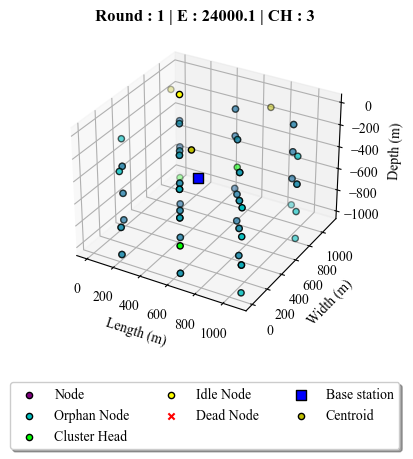

Round : 0 | PATH : [9, 0] | node.energy : 499.998
Round : 0 | PATH : [11, 0] | node.energy : 499.998
Round : 0 | PATH : [12, 0] | node.energy : 499.998
Round : 0 | PATH : [23, 0] | node.energy : 499.998
Round : 0 | PATH : [33, 0] | node.energy : 499.998
Round : 0 | PATH : [37, 0] | node.energy : 499.998
Round : 0 | PATH : [38, 0] | node.energy : 499.998
Round : 0 | PATH : [45, 0] | node.energy : 499.998
Round : 0 | PATH : [47, 0] | node.energy : 499.998
Round : 1 | PATH : [3, 0] | node.energy : 478.45743941496244
Round : 1 | PATH : [4, 0] | node.energy : 499.998
Round : 1 | PATH : [7, 0] | node.energy : 381.6443454077423
Round : 1 | PATH : [8, 0] | node.energy : 381.6443454077424
Round : 1 | PATH : [9, 0] | node.energy : 455.4247436714158
Round : 1 | PATH : [10, 0] | node.energy : 381.65153428934315
Round : 1 | PATH : [11, 0] | node.energy : 476.8583583565755
Round : 1 | PATH : [12, 0] | node.energy : 463.75102167476615
Round : 1 | PATH : [15, 0] | node.energy : 222.55230374192882
Roun

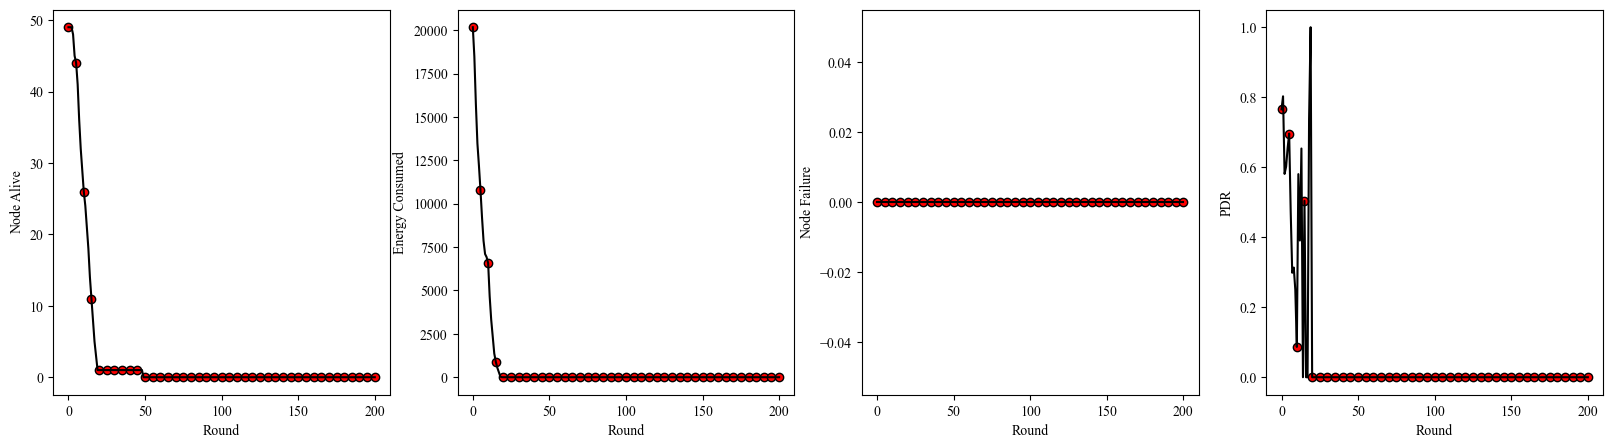

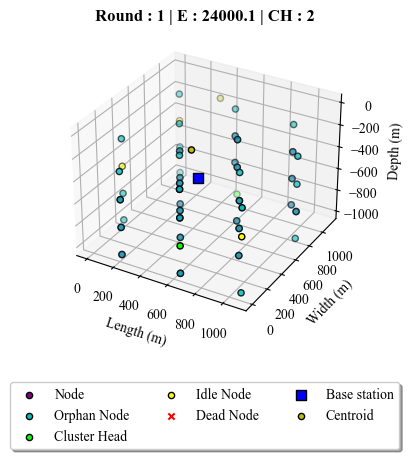

Round : 0 | PATH : [2, 0] | node.energy : 499.998
Round : 0 | PATH : [4, 0] | node.energy : 499.998
Round : 0 | PATH : [9, 0] | node.energy : 499.998
Round : 0 | PATH : [11, 0] | node.energy : 499.998
Round : 0 | PATH : [14, 0] | node.energy : 499.998
Round : 0 | PATH : [16, 0] | node.energy : 499.998
Round : 0 | PATH : [35, 0] | node.energy : 499.998
Round : 0 | PATH : [37, 0] | node.energy : 499.998
Round : 0 | PATH : [38, 0] | node.energy : 499.998
Round : 0 | PATH : [39, 0] | node.energy : 499.998
Round : 0 | PATH : [40, 0] | node.energy : 499.998
Round : 0 | PATH : [42, 0] | node.energy : 499.998
Round : 0 | PATH : [44, 0] | node.energy : 499.998
Round : 0 | PATH : [45, 0] | node.energy : 499.998
Round : 0 | PATH : [46, 0] | node.energy : 499.998
Round : 0 | PATH : [47, 0] | node.energy : 499.998
Round : 0 | PATH : [48, 0] | node.energy : 499.998
Round : 1 | PATH : [9, 0] | node.energy : 455.4247436714158
Round : 1 | PATH : [10, 0] | node.energy : 381.8407509669419
Round : 1 | PAT

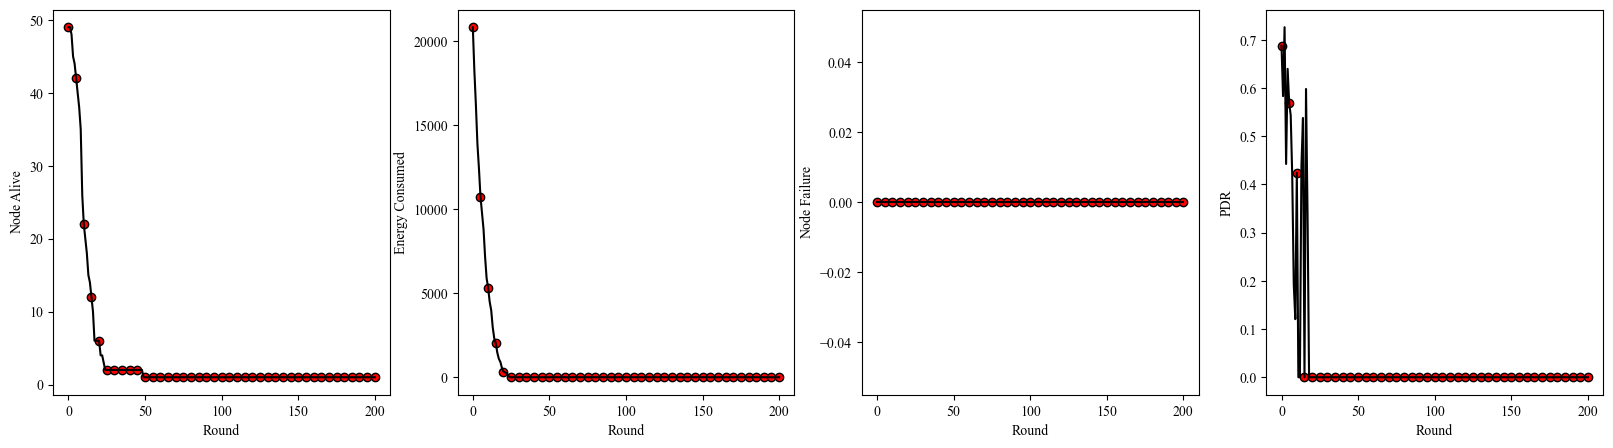

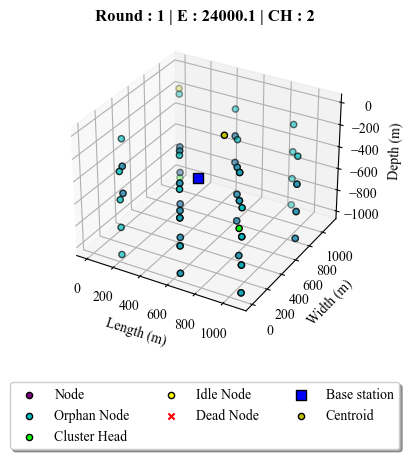

Round : 0 | PATH : [1, 0] | node.energy : 499.998
Round : 0 | PATH : [12, 0] | node.energy : 499.998
Round : 0 | PATH : [13, 0] | node.energy : 499.998
Round : 0 | PATH : [24, 0] | node.energy : 499.998
Round : 0 | PATH : [25, 0] | node.energy : 499.998
Round : 0 | PATH : [36, 0] | node.energy : 499.998
Round : 0 | PATH : [37, 0] | node.energy : 499.998
Round : 0 | PATH : [38, 0] | node.energy : 499.998
Round : 0 | PATH : [40, 0] | node.energy : 499.998
Round : 0 | PATH : [41, 0] | node.energy : 499.998
Round : 0 | PATH : [42, 0] | node.energy : 499.998
Round : 0 | PATH : [43, 0] | node.energy : 499.998
Round : 0 | PATH : [44, 0] | node.energy : 499.998
Round : 0 | PATH : [45, 0] | node.energy : 499.998
Round : 0 | PATH : [47, 0] | node.energy : 499.998
Round : 0 | PATH : [48, 0] | node.energy : 499.998
Round : 1 | PATH : [1, 0] | node.energy : 483.02143286506947
Round : 1 | PATH : [2, 0] | node.energy : 499.998
Round : 1 | PATH : [3, 0] | node.energy : 478.6471042867292
Round : 1 | PA

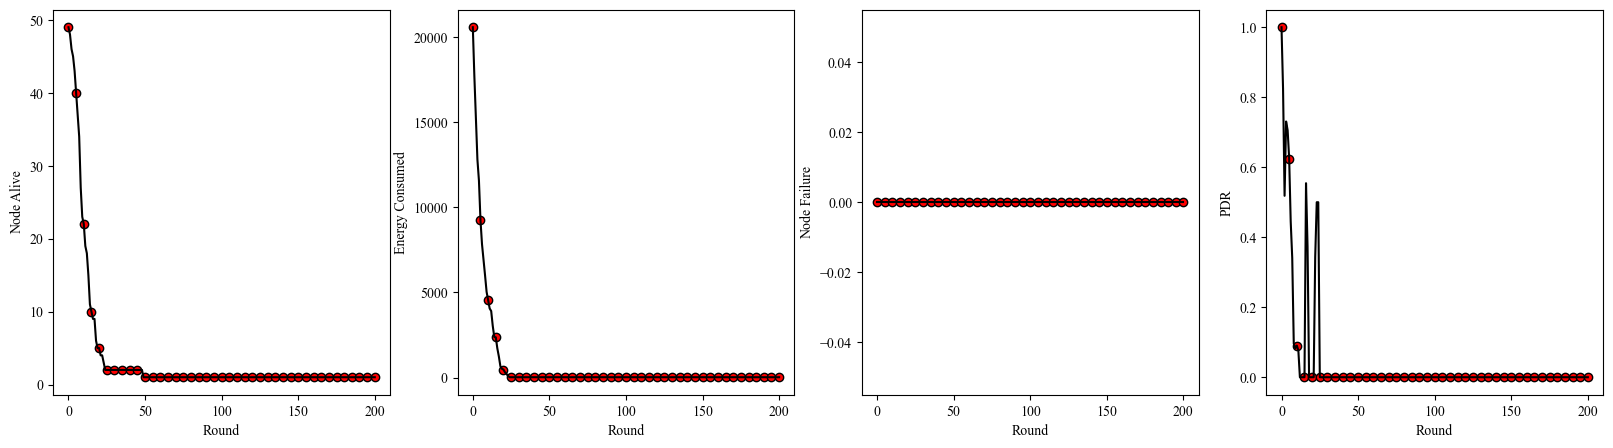

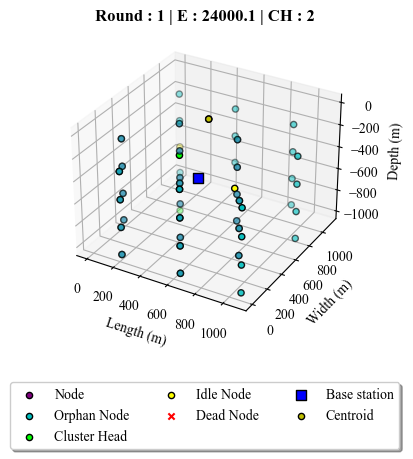

Round : 0 | PATH : [4, 0] | node.energy : 499.998
Round : 0 | PATH : [9, 0] | node.energy : 499.998
Round : 0 | PATH : [11, 0] | node.energy : 499.998
Round : 0 | PATH : [12, 0] | node.energy : 499.998
Round : 0 | PATH : [20, 0] | node.energy : 499.998
Round : 0 | PATH : [21, 0] | node.energy : 499.998
Round : 0 | PATH : [23, 0] | node.energy : 499.998
Round : 0 | PATH : [24, 0] | node.energy : 499.998
Round : 0 | PATH : [28, 0] | node.energy : 499.998
Round : 0 | PATH : [32, 0] | node.energy : 499.998
Round : 0 | PATH : [33, 0] | node.energy : 499.998
Round : 0 | PATH : [35, 0] | node.energy : 499.998
Round : 0 | PATH : [36, 0] | node.energy : 499.998
Round : 0 | PATH : [40, 0] | node.energy : 499.998
Round : 0 | PATH : [44, 0] | node.energy : 499.998
Round : 0 | PATH : [45, 0] | node.energy : 499.998
Round : 0 | PATH : [47, 0] | node.energy : 499.998
Round : 0 | PATH : [48, 0] | node.energy : 499.998
Round : 1 | PATH : [1, 0] | node.energy : 381.81558988133884
Round : 1 | PATH : [2, 

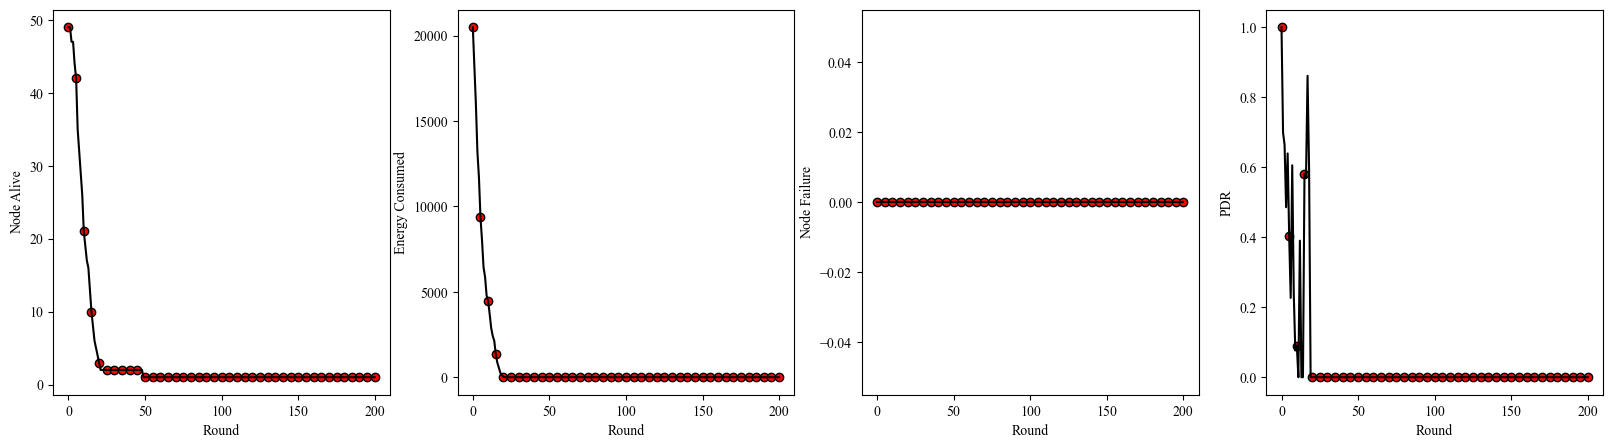

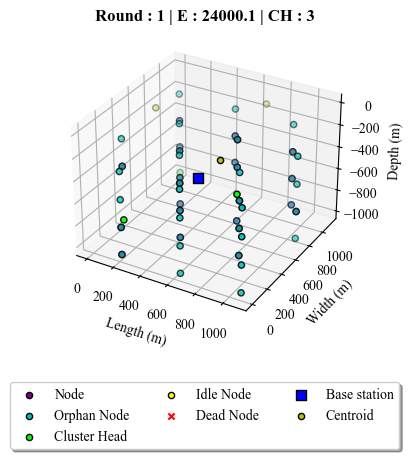

Round : 0 | PATH : [5, 0] | node.energy : 499.998
Round : 0 | PATH : [9, 0] | node.energy : 499.998
Round : 0 | PATH : [11, 0] | node.energy : 499.998
Round : 0 | PATH : [17, 0] | node.energy : 499.998
Round : 0 | PATH : [21, 0] | node.energy : 499.998
Round : 0 | PATH : [25, 0] | node.energy : 499.998
Round : 0 | PATH : [29, 0] | node.energy : 499.998
Round : 0 | PATH : [33, 0] | node.energy : 499.998
Round : 0 | PATH : [35, 0] | node.energy : 499.998
Round : 0 | PATH : [37, 0] | node.energy : 499.998
Round : 0 | PATH : [38, 0] | node.energy : 499.998
Round : 0 | PATH : [39, 0] | node.energy : 499.998
Round : 0 | PATH : [40, 0] | node.energy : 499.998
Round : 0 | PATH : [41, 0] | node.energy : 499.998
Round : 0 | PATH : [42, 0] | node.energy : 499.998
Round : 0 | PATH : [44, 0] | node.energy : 499.998
Round : 0 | PATH : [45, 0] | node.energy : 499.998
Round : 0 | PATH : [46, 0] | node.energy : 499.998
Round : 0 | PATH : [47, 0] | node.energy : 499.998
Round : 0 | PATH : [48, 0] | node

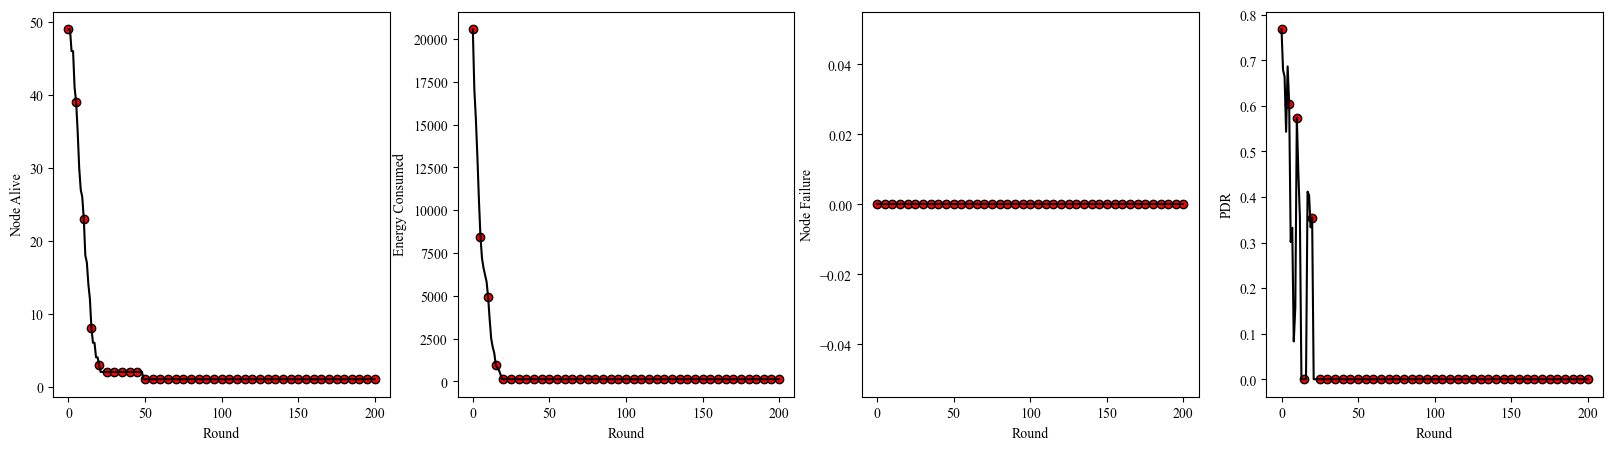

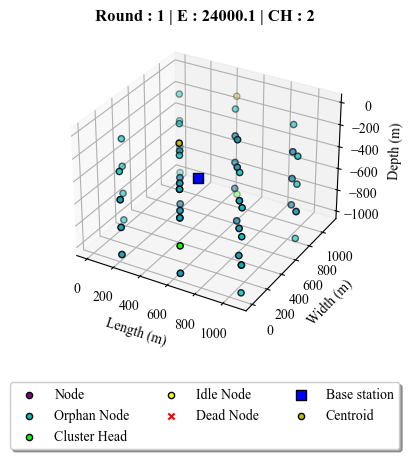

Round : 0 | PATH : [2, 0] | node.energy : 499.998
Round : 0 | PATH : [4, 0] | node.energy : 499.998
Round : 0 | PATH : [9, 0] | node.energy : 499.998
Round : 0 | PATH : [11, 0] | node.energy : 499.998
Round : 0 | PATH : [14, 0] | node.energy : 499.998
Round : 0 | PATH : [16, 0] | node.energy : 499.998
Round : 0 | PATH : [26, 0] | node.energy : 499.998
Round : 0 | PATH : [28, 0] | node.energy : 499.998
Round : 0 | PATH : [33, 0] | node.energy : 499.998
Round : 0 | PATH : [35, 0] | node.energy : 499.998
Round : 0 | PATH : [37, 0] | node.energy : 499.998
Round : 0 | PATH : [38, 0] | node.energy : 499.998
Round : 0 | PATH : [39, 0] | node.energy : 499.998
Round : 0 | PATH : [40, 0] | node.energy : 499.998
Round : 0 | PATH : [42, 0] | node.energy : 499.998
Round : 0 | PATH : [44, 0] | node.energy : 499.998
Round : 0 | PATH : [45, 0] | node.energy : 499.998
Round : 0 | PATH : [46, 0] | node.energy : 499.998
Round : 0 | PATH : [47, 0] | node.energy : 499.998
Round : 0 | PATH : [48, 0] | node.

KeyboardInterrupt: 

In [26]:
epoch = 1000
gamma = 0.5
epsilon_start = 0.0
epsilon_end = 0.9
file_path = f'TRIAL_III_EPOCH_{epoch}_GAMMA_{gamma}_EPSILON_[{epsilon_start}-{epsilon_end}]_QL_tuning.xlsx'
count = 0


if os.path.exists(file_path):
    df_tuning_result = pd.read_excel(file_path)
    for epsilon in [i for i in range(int(epsilon_start * 10), int(epsilon_end * 10)+1)]:
        epsilon = epsilon * 0.1
        for alpha in range(1, 11):
            start_time = time.time()
            alpha = alpha * 0.1
            QL_params = {
                'EPOCH'   : epoch,
                'EPSILON' : epsilon,
                'GAMMA'   : gamma,
                'ALPHA'   : alpha
            }
            start_time         = time.time()
            node_Q_Learning    = createNetworks()
            Q_Learning = networkEnvironment(node_Q_Learning, "Q-Learning", False, 201, QL_params)
            Q_Learning_params = Q_Learning.startSimulation(200)
            energy            = sum(Q_Learning_params['Energy Residual'])

            end_time = time.time()  
            time_taken = end_time - start_time
            print(f"{time_taken:.2f} | {count} | epsilon : {epsilon} | alpha : {alpha} | gamma : {gamma} | E : {energy}")
            end_time = time.time()

            result = {
                'EPOCH'   : [epoch  ],
                'EPSILON' : [epsilon],
                'GAMMA'   : [gamma  ],
                'ALPHA'   : [alpha  ]
            }
            for param in Q_Learning_params.keys():
                temp = Q_Learning_params[param]
                temp = sum(temp)/len(temp)
                result[param] = [temp]
                
            result = pd.DataFrame(result)
            df_tuning_result = pd.read_excel(file_path)
            df_tuning_result = pd.concat(
                [df_tuning_result, result], 
                ignore_index=True
            )
            print(df_tuning_result.tail(5))
            df_tuning_result.to_excel(file_path, index=False)
            count += 1
else:
    df_tuning_result = {
        'EPOCH'   : [],
        'EPSILON' : [],
        'GAMMA'   : [],
        'ALPHA'   : [],
        'Alive'                     : [],
        'Energy Residual'           : [],
        'Node Failure'              : [],
        'PDR'                       : [],
        'Total Packet Sent'         : [],
        'Energy Setup Consumed'     : [],
        'Energy Steady Consumed'    : []
    }
    df_tuning_result = pd.DataFrame(df_tuning_result)
    df_tuning_result.to_excel(file_path, index=False)

count += 1

In [ ]:
play_sound(8)

In [ ]:
node_Q_Learning    = createNetworks()
QL = networkEnvironment(node_LEACH, "LEACH", False, 200, QL_params)
LEACH_params = LEACH.startSimulation(500)

In [ ]:
node_LEACH    = createNetworks()
LEACH = networkEnvironment(node_LEACH, "LEACH", False, 200, QL_params)
LEACH_params = LEACH.startSimulation(500)

In [ ]:
node_DECKS    = createNetworks()
DECKS = networkEnvironment(node_DECKS, "DECKS", False, 200, QL_params)
DECKS_params = DECKS.startSimulation(200)

In [ ]:
node_KMeans    = createNetworks()
KMeans = networkEnvironment(node_KMeans, "K-Means", False, 200, QL_params)
K_Means_params = KMeans.startSimulation(200)

In [ ]:
fig, ax = plt.subplots(len(min_QL_params.keys()), 1, figsize=(8, 24), dpi=150)

markers = ['o', 's', '^', 'v', 'x', 'h', 'P']
colors = ['g', 'r', 'b', 'y', 'purple', 'lime']


hop = 10
round_interval = 200
count = 0
method_names = ["LEACHs", "K_Mean", "DECKS", "QL"]

for param in min_QL_params.keys():
    rounds = [i for i in range(len(max_QL_params['Alive']))]
    ax[count].plot(rounds[:round_interval][::hop], min_QL_params    [param]        [:round_interval][::hop], color='k', linestyle='--', linewidth=0.8, marker=markers[0], mfc=colors[0], markeredgecolor='k', zorder=0, label="Min"          )
    ax[count].plot(rounds[:round_interval][::hop], max_QL_params  [param]          [:round_interval][::hop], color='k', linestyle='--', linewidth=0.8, marker=markers[1], mfc=colors[1], markeredgecolor='k', zorder=0, label="Max"        )
    ax[count].plot(rounds[:round_interval][::hop], avg_QL_params    [param]        [:round_interval][::hop], color='k', linestyle='--', linewidth=0.8, marker=markers[2], mfc=colors[2], markeredgecolor='k', zorder=0, label="Average"          )
    ax[count].plot(rounds[:round_interval][::hop], LEACH_params[param]             [:round_interval][::hop], color='k', linestyle='--', linewidth=0.8, marker=markers[3], mfc=colors[3], markeredgecolor='k', zorder=0, label="LEACH"          )
    ax[count].plot(rounds[:round_interval][::hop], K_Means_params[param]           [:round_interval][::hop], color='k', linestyle='--', linewidth=0.8, marker=markers[4], mfc=colors[4], markeredgecolor='k', zorder=0, label="K-Means"        )
    ax[count].plot(rounds[:round_interval][::hop], DECKS_params[param]             [:round_interval][::hop], color='k', linestyle='--', linewidth=0.8, marker=markers[5], mfc=colors[5], markeredgecolor='k', zorder=0, label="DECKS"          )
    ax[count].set_xlabel('Number of Rounds'    , fontsize=14)
    ax[count].set_title(param    , fontsize=14)
    ax[count].legend()
               
    # ax.set_ylabel('Energy (J)'          , fontsize=14)

    # ax.yaxis.set_major_locator(MultipleLocator(10))
    # ax.yaxis.set_major_formatter('{x:.2f}')
    # ax.yaxis.set_minor_locator(MultipleLocator(2))
    # ax.xaxis.set_major_locator(MultipleLocator(20))
    # ax.xaxis.set_major_formatter('{x:.2f}')
    # ax.xaxis.set_minor_locator(MultipleLocator(5))

    # ax.xaxis.set_tick_params(labelsize=12)
    # ax.yaxis.set_tick_params(labelsize=12)
    # # ax.set_title(param, fontsize=12)
    count += 1
plt.tight_layout()
plt.show()